In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint

2024-10-26 00:42:43.732114: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 00:42:43.733036: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 00:42:43.752758: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 00:42:43.773983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 00:42:43.816499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# Если вам нужно разделить на train, val и test
import splitfolders

input_folder = "./res/deep_fake/content/dataset" #Enter Input Folder
output = "./res/deep_fake/content/ready_dataset" #Enter Output Folder

# This library split folders with files (e.g. images) into train, validation and test (dataset) folders.
# Ссылка на документацию по использованию: https://pypi.org/project/split-folders/
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 10000 files [00:05, 1824.68 files/s]


In [3]:
batch_size = 32  # размер мини-пакета
img_height = 224 # высота изображения
img_width = 224  # длина изображения

# Создание обучающего набора данных:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='./res/deep_fake/content/ready_dataset/train', # путь к папке с обучающими данными
  label_mode = 'int',       # представление правильных ответов картинок в виде чисел (Label Encoding): 0, 1, 2, 3... (Также можно использовать One-Hot Encoding, для этого напишите categorical) (Если у вас задача бинарной классификации пишите binary)
  color_mode='rgb',         # представление каждой картинки в RGB формате
  batch_size=batch_size,    # параметр, с помощью которого можно регулировать порцию подаваемых примеров (картинок) для сети за одну итерацию обучения
  seed=123,                 # фиксированный seed для случайных процессов (например, перетасовки)
  image_size=(img_height, img_width), # нейронная сеть всегда принимает изображение определённого размера. Поэтому необходимо предварительно поменять размер каждого изображения
  shuffle=True)                       # перетасовка данных, чтобы генерировать данные не в определённом порядке (сначала 1 класс, потом 2 класс), а случайным образом

# Создание валидационного набора данных:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='./res/deep_fake/content/ready_dataset/val',  # путь к папке с валидационный данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False) # Отключаем shuffle (перемешивание), чтобы сохранить порядок данных и избежать внесения случайных изменений в процесс оценки модели.

# Создание тестового набора данных:
test_ds = tf.keras.utils.image_dataset_from_directory(
  directory='./res/deep_fake/content/ready_dataset/test',  # путь к папке с тестовыми данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False) # Отключаем shuffle (перемешивание), чтобы сохранить порядок данных и избежать внесения случайных изменений в процесс оценки модели.

# здесь вы можете найти документацию по данному генератору: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
class_names = train_ds.class_names # список классов
num_classes = len(class_names) # количество классов, чтобы указать их в последнем выходном слое
print(class_names)
print(num_classes)

['fake', 'real']
2


2024-10-26 00:42:51.700152: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


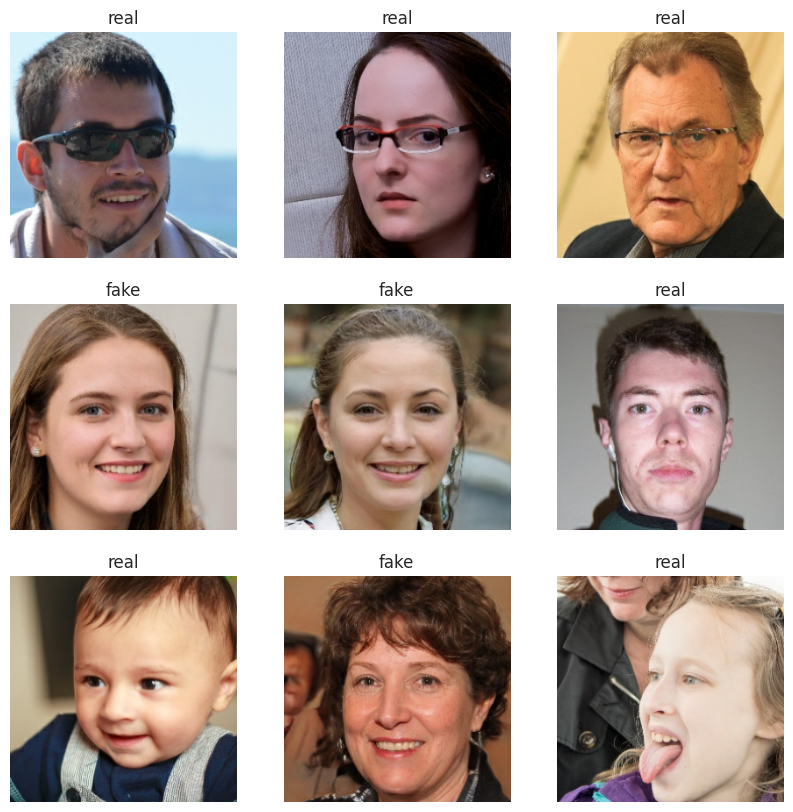

In [5]:
import matplotlib.pyplot as plt

# Визуализация примеров из тренировочного набора данных

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
def createModel(input_shape):
  # Входной слой
  input_layer = Input(shape=input_shape)

  # Здесь можно добавить ваш слой с аугментацией (см. туториал: https://tensorflow.google.cn/tutorials/images/classification?hl=ru#data_augmentation)

  # Нормализация данных от 0 до 1
  normalized_layer = Rescaling(1./255)(input_layer)

  # 1 блок свёртки (Conv + ReLU + MaxPool)
  conv_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same') (normalized_layer)
  pool_1 = MaxPooling2D(2, 2) (conv_1)

  # 2 блок свёртки (Conv + ReLU + MaxPool)
  conv_2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same') (pool_1)
  pool_2 = MaxPooling2D(2, 2) (conv_2)

  # 3 блок свёртки (Conv + ReLU + MaxPool)
  conv_3 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same') (pool_2)
  pool_3 = MaxPooling2D(2, 2) (conv_3)

  # 4 блок свёртки (Conv + ReLU + MaxPool)
  conv_4 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same') (pool_3)
  pool_4 = MaxPooling2D(2, 2) (conv_4)

  # Классификационный слой

  # 1. Вариант с промежутночным полностью связанным слоев (количество нейронов выбирайте с умом)
  # flatten_features = Flatten() (pool_4)
  # ffn = Dense(256, activation='relu') (flatten_features)
  # output = Dense(num_classes, activation='softmax') (ffn)

  # 2. Вариант с Global Average Pooling (глобальное усреднение по карте признаков)
  averaged_features = GlobalAveragePooling2D() (pool_4) # усредняет каждый канал выходных признаков, что помогает уменьшить количество параметров и предотвращает переобучение.
  # Полносвязный слой для классификации с функцией активации софтмакс для получения вероятностей классов
  output = Dense(num_classes, activation='sigmoid') (averaged_features)

  return Model(inputs=input_layer, outputs=output)

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential

# Пример загрузки предварительно обученной модели.

# Загрузка предварительно обученной сети ResNet50 на наборе данных ImageNet (1000 классов различных объектов, более 1 млн. изображений).
# Чтобы использовать эту готвую сеть для вашей задачи, необходимо заменить классификационный слой на новый (поскольку там выходной слой с 1000 нейронами), указав ваше необходимое количество классов.

def create_pretrained_resnet50(input_shape):
  # weights='imagenet' — здесь указано, что модель будет загружена с уже обученными весами из ImageNet.
  # include_top=False — этот параметр означает, что последняя (выходная) часть модели, которая отвечает за классификацию, будет удалена. Мы это делаем, потому что у нас может быть другое количество классов в нашей задаче, и мы хотим заменить её на свою классификационную часть.
  # input_shape=(224, 224, 3) — задаётся форма входного изображения: 224x224 пикселя и 3 канала (RGB).
  resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  model = Sequential()
  model.add(resnet50)                                 # добавляется вся сеть ResNet50 как начальная часть модели, отвечающая за извлечение признаков (features) из изображений.
  model.add(GlobalAveragePooling2D())                 # глобальное усреднение по карте признаков
  model.add(Dense(num_classes, activation='sigmoid')) # добавляется финальный полносвязный слой, где количество нейронов равно количеству классов в задаче (num_classes)
  return model

In [8]:
def trainModel(train_dataset, val_dataset):
  # Сохранение только наилучшей модели с наименьшей ошибкой на валидации
  save_callback = ModelCheckpoint(filepath='./res/deep_fake/best_model.weights.h5', # путь и название файла лучшей модели.
                                  monitor = 'val_loss',             # отслеживать каждую эпоху показать val_loss
                                  save_best_only = True,            # сохранять только самую лучшую модель
                                  save_weights_only=True,           # сохранять только веса модели (не всю модель);
                                  mode = 'min',                     # режим оптимизации min (найти минимальную ошибку)
                                  verbose=1)                        # 1 означает выводить информацию о нахождении и сохранении лучшей модели в процессе обучения, 0 означает не выводить.

  model = createModel((img_height, img_width, 3))                   # создание нашей свёрточной нейронной сети (размерность входа равна (img_height, img_width, 3))

  # model = create_pretrained_resnet50((img_height, img_width, 3))       # создание предварительно обученной свёрточной нейронной сети ResNet50 (для переноса обучения)

  # Компиляция модели
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # алгоритм градиентного спуска, минимизирующий функцию ошибки. В нём можно задать скорость обучения (по умолчанию 0.001)
                loss='sparse_categorical_crossentropy',                  # функция ошибки sparse_categorical_crossentropy (поскольку метки представлены целыми числами int) категориальная кроссэнтропия для задачи многоклассовой классификации.
                metrics=['sparse_categorical_accuracy'])                 # метрика accuracy - точность.

  model.summary() # вывод информации о созданной модели

  model.fit(train_dataset,               # указываем обучающий набор данных
            validation_data=val_dataset, # указываем валидационный набор данных
            epochs=30,                   # количество эпох обучения. эпоха представляет собой один полный проход через все данные обучающего набора.
            callbacks=[save_callback]    # используем в процессе обучения созданный ModelCheckpoint
            )
  return model

In [9]:
# Перед обучением обязательно включите GPU: "Среда выполнения" -> "Сменить среду выполнения" -> "T4 GPU"
# Запуск обучения модели
model = trainModel(train_ds, val_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,930 (1.48 MB)

 Trainable params: 388,930 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.5045
Epoch 1: val_loss improved from inf to 0.69312, saving model to ./res/deep_fake/best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 579ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.5045 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.5120
Epoch 2: val_loss did not improve from 0.69312
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 576ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.5120 - val_loss: 0.6936 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.6916 - sparse_categorical_accuracy: 0.5207
Epoch 3: val_loss improved from 0.69312 to 0.68711, saving model to ./res/deep_fake/best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 573ms/step - loss: 0.6916 - sparse_categorical_accuracy: 0.5208 - val_lo

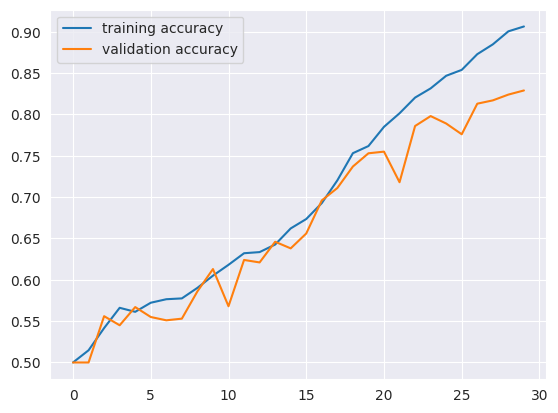

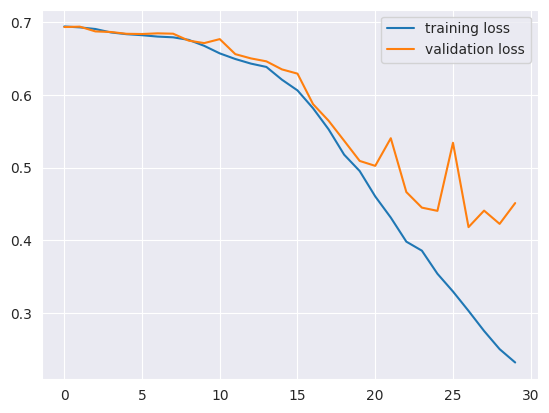

In [10]:
# Вывод графиков обучения

plt.figure()
plt.plot(model.history.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(model.history.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [11]:
# Загрузка весов самой лучшей модели с самой маленькой ошибкой
model.load_weights('./res/deep_fake/best_model.weights.h5')

In [12]:
# Тестирование на тестовых данных
loss, accuracy = model.evaluate(test_ds)
print("Точность модели CNN: " + str(accuracy))

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.5001 - sparse_categorical_accuracy: 0.7886
Точность модели CNN: 0.8259999752044678


2024-10-26 01:57:42.175742: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Предсказанный ответ: fake
Правильный ответ: fake


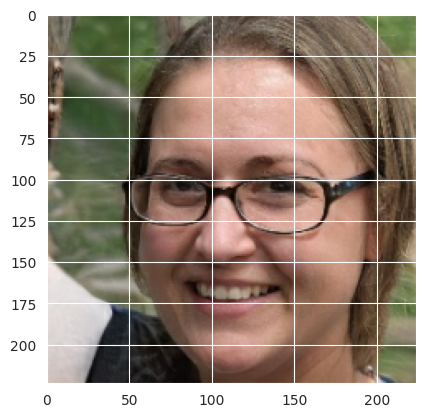

In [13]:
# Здесь мы берём каждый раз случайное изображение из test_ds и предсказываем для него класс.
# Эту ячейку можно запускать много раз и смотреть результаты классификации для разных картинок.

for image_batch, label_batch in test_ds.shuffle(buffer_size=len(list(test_ds))).take(1):
    # Выбираем случайный индекс изображения из мини-пакета
    random_index = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(image_batch)[0], dtype=tf.int32)
    # Извлекаем случайное изображение и метку
    image = image_batch[random_index]
    label = label_batch[random_index]
    predictions = model.predict(tf.expand_dims(image, axis=0))
    # Get the predicted class label
    predicted_class_index = tf.argmax(predictions, axis=-1)
    predicted_class_label = test_ds.class_names[predicted_class_index[0]]
    # Print the predicted class label and true label
    print("Предсказанный ответ:", predicted_class_label)
    print("Правильный ответ:", test_ds.class_names[label])
    plt.imshow(image.numpy().astype("uint8"))

In [14]:
# Вывод classification report на тестовых данных
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
print("Classification Report for Our Convolutional Neural Network")
print(classification_report(true_labels, predicted_labels))

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step
Classification Report for Our Convolutional Neural Network
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       500
           1       0.80      0.87      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



2024-10-26 01:57:49.527602: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
